# Tutorial

author: Qiuzi Chen  
article links: <https://doi.org/10.1016/j.trd.2023.103724>

---

## 1 Initialize an EVSP

In [1]:
import pandas as pd
from EVSPModel import EVSP

In [2]:
# input timetable
timetable = pd.read_excel('Data\T275_Ave.xlsx')
timetable.head()

,Unnamed: 0,ID,Route,StartTime,StartTimeMin,TravelTimeMin,Distance,Consumption,TimeDivision
0,0,1,52,05:25:00,325,94,25.8,17.908607,off-peak
1,1,2,4,05:30:00,330,78,24.8,18.930295,m&n
2,2,3,52,05:38:00,338,94,25.8,17.908607,off-peak
3,3,4,4,05:40:00,340,78,24.8,18.930295,m&n
4,4,5,4,05:49:00,349,78,24.8,18.930295,m&n


### Default parameters

In [3]:
# initialize an EVSP with default params
evsp = EVSP(timetable)
evsp.setVehTypes()
evsp.setCosts()
evsp.setChargingFunc()
evsp.createModel()
evsp.printParams()

--- EVSP Parameters --- 
 Number of Trips: 275 
 Number of Vehicle Types: 3 
 Battery Capacity: {1: 100, 2: 170, 3: 258} 
 Safe Range of Battery Level: 0.2 1.0 
 Station Capacity: not considered 
 Allow Line Change: True 
 Adopt Night Change: False 
 Charging Function: linear 
 Time Interval: 10 
 Fixed Recharging Time: 30


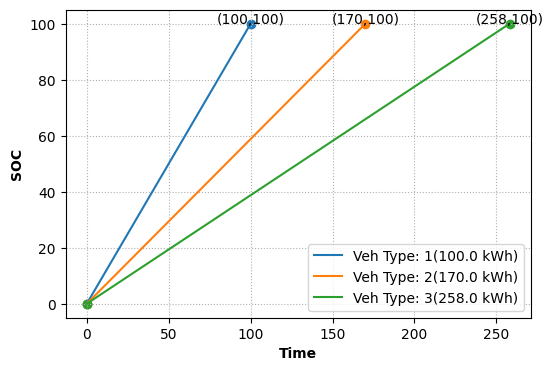

In [4]:
evsp.plotChargingFunc()

### Self-defined params

- Operation params

In [5]:
evsp = EVSP(
    timetable,
    batteryLB=0.2, batteryUB=0.8,  # safe battery level
    stationCap=10,  # number of chargers in the station
    delta=10, U=3,  # time division params
    lineChange=True,  # allow line change
    nightCharge=False  # not adopted night charge
)

- Vehicle params

In [6]:
E_k = {  # veh_type_id: battery capacity / kWh
    1: 100,
    2: 200,
}

evsp.setVehTypes(
    E_k=E_k,
    capRelatedCons=True,  # energy consumption of each type is considered linearly related to the battery weight and capacity
    benchCap=200,  # to consider capRelatedCons, we need to define a benchmark capacity
    consIncRate=0.000297  # the increasing rate is obtained from literature
)

- Cost params

In [7]:
evsp.setCosts(
    calVehCost=True, c_k={1: 800, 2: 900},  # vehicle depreciation cost
    calElecCost=True, c_e=0.6,  # electricity cost
    calTimeCost=True, c_t=0.5,  # time-related cost, generated from labors and delay
)

- Charging function

The framework supports both linear charging and nonlinear charging function, which can be selected by the parameter `chargingFuncType`.

Linear charging function is controlled by `chargingRate` in unit of kWh/min.

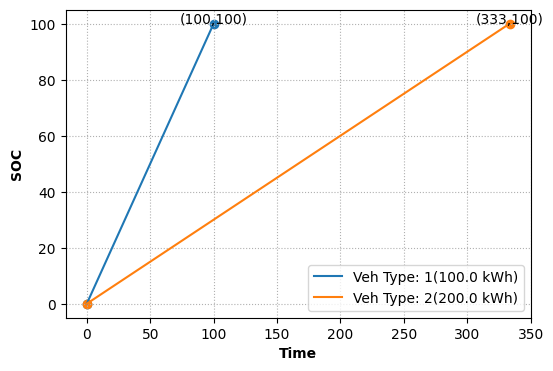

In [8]:
evsp.setChargingFunc(
    chargingFuncType='linear',
    chargingRate={1:1, 2: 0.6}  # kWh/min
)
evsp.plotChargingFunc()

Nonlinear charging function is controlled by both `breakpoint_time` and `breakpoint_soc`. These two params determine the position of each breakpoint in the piece-wise nonlinear charging curve.

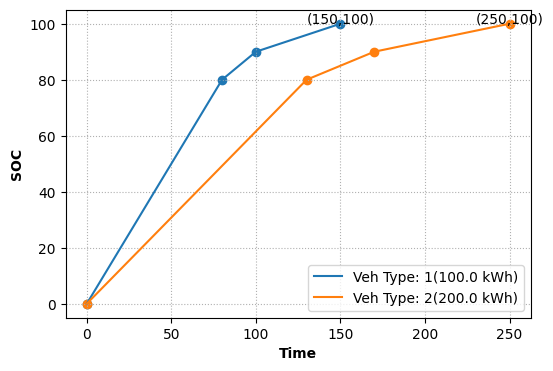

In [9]:
evsp.setChargingFunc(
    chargingFuncType='piecewise',
    breakpoint_time={1:[0,80,100,150,300], 2:[0,130,170,250,400]},  # min
    breakpoint_soc={1:[0.0,0.8,0.9,1.0,1.0], 2:[0.0,0.8,0.9,1.0,1.0]}  # soc
)
evsp.plotChargingFunc()

In [10]:
evsp.createModel()
evsp.printParams()

--- EVSP Parameters --- 
 Number of Trips: 275 
 Number of Vehicle Types: 2 
 Battery Capacity: {1: 100, 2: 200} 
 Safe Range of Battery Level: 0.2 0.8 
 Station Capacity: 10 
 Allow Line Change: True 
 Adopt Night Change: False 
 Charging Function: piecewise 
 Time Interval: 10 
 Fixed Recharging Time: 30


---

## 2 Solving an EVSP

In [1]:
import pandas as pd
from EVSPModel import EVSP
from ALNS import ALNS

In [14]:
# input timetable
timetable = pd.read_excel('Data\T275_Ave.xlsx')

### Solve with default params

In [15]:
# initialize an EVSP with default params
evsp = EVSP(timetable)
evsp.setVehTypes()
evsp.setCosts()
evsp.setChargingFunc()
evsp.createModel()
evsp.printParams()

--- EVSP Parameters --- 
 Number of Trips: 275 
 Number of Vehicle Types: 3 
 Battery Capacity: {1: 100, 2: 170, 3: 258} 
 Lowest Battery Level: 0.2 
 Station Capacity: not considered 
 Allow Line Change: True 
 Adopt Night Change: False 
 Charging Function: linear 
 Time Interval: 10 
 Fixed Recharging Time: 30


In [16]:
alns = ALNS(evsp)
alns.solve()

--- ALNS Starts
--- Terminate at 6700 Iteration
--- Solve Time: 40.22 sec
--- Best Cost: 50104.30 yuan
--- Number of Buses: 38
--- Number of Charging Trips: 63
--- ALNS Finished


- Plot the variation of weights and costs during the solving procedure.

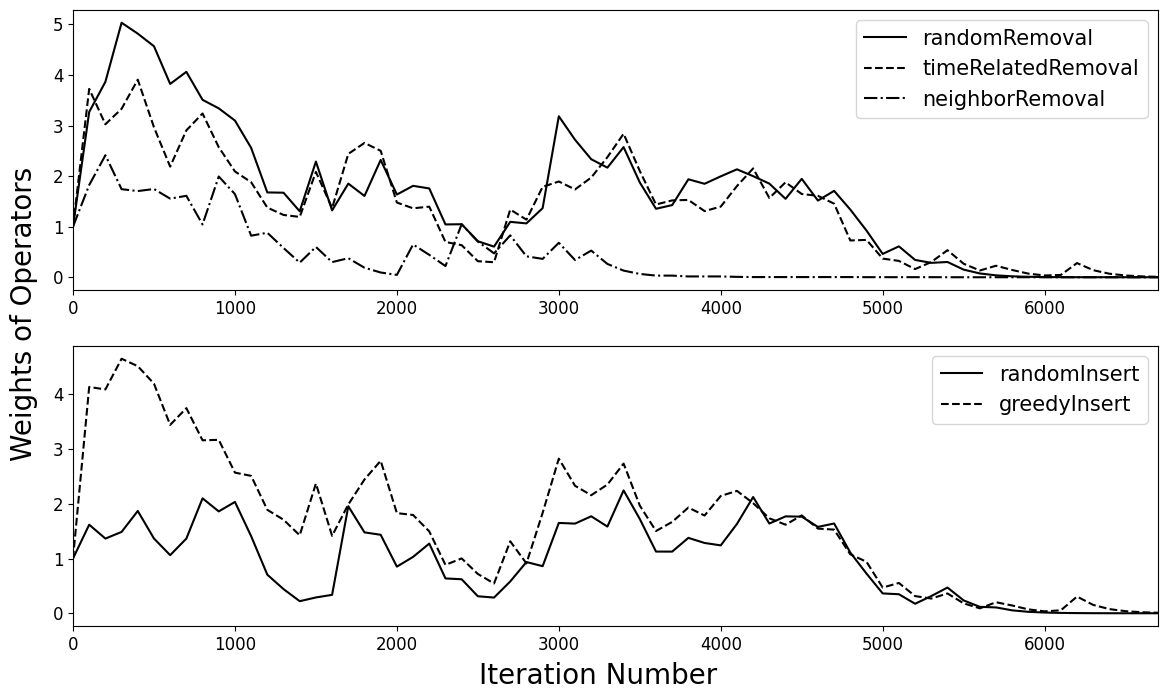

In [17]:
alns.plotWeights()

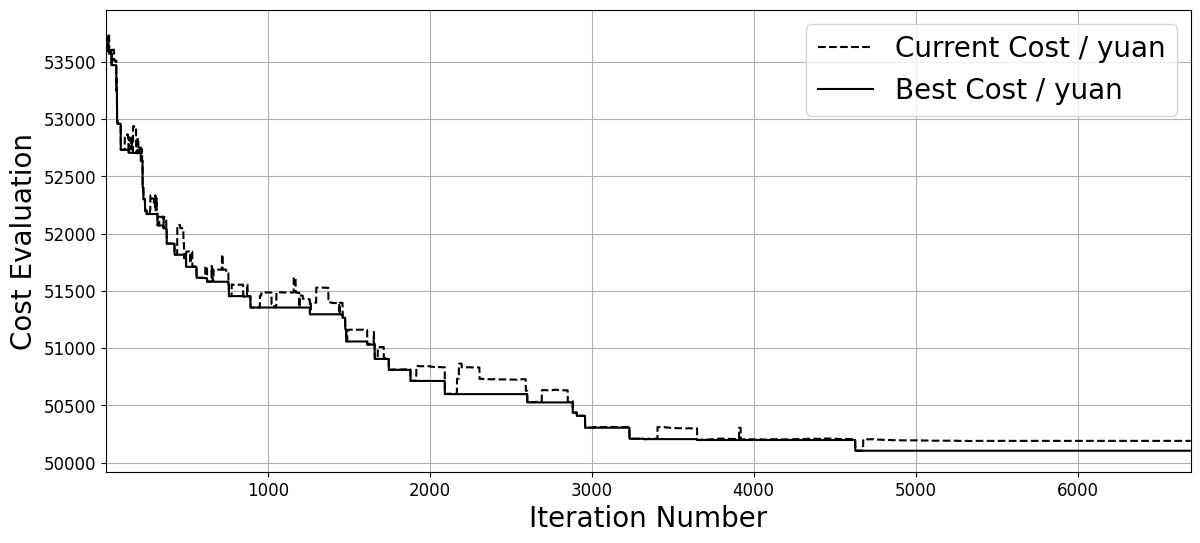

In [18]:
alns.plotEvaluation()

- Plot the best schedule.

In [19]:
bestS = alns.bestSchedule  # the best schedule stored in the ALNS object

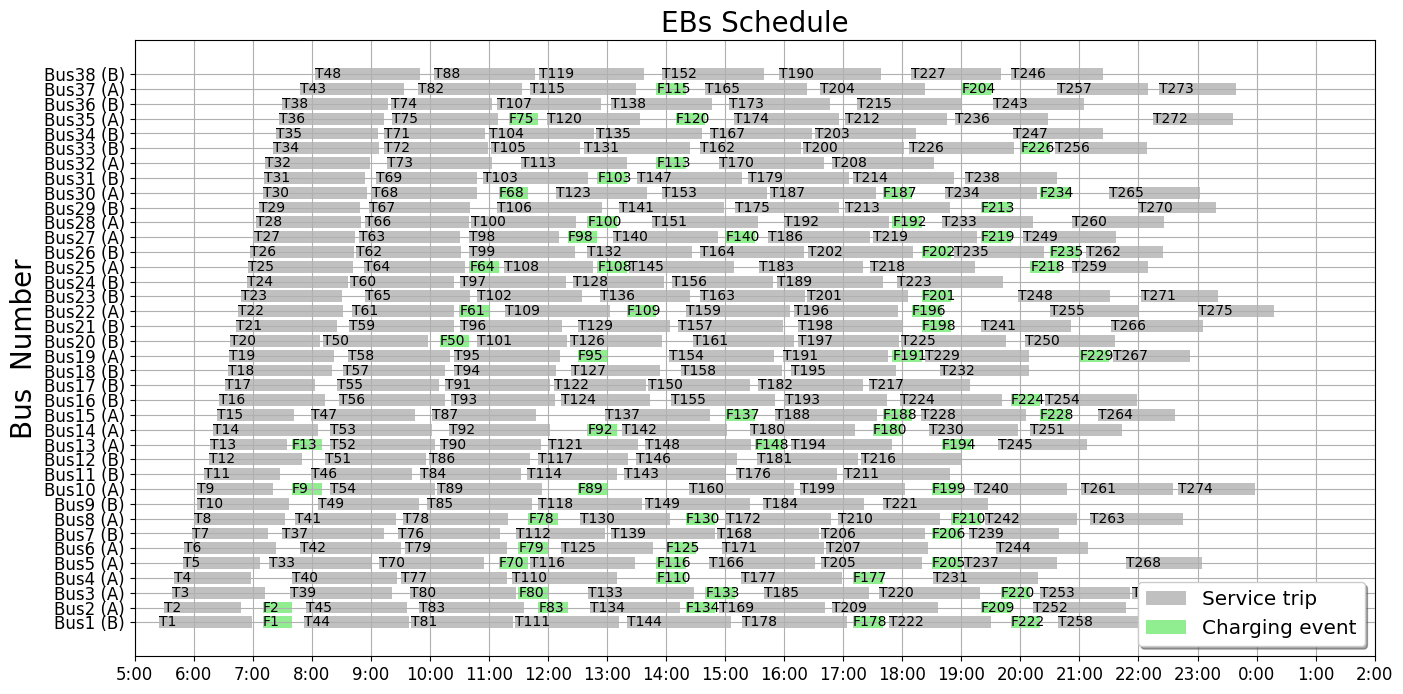

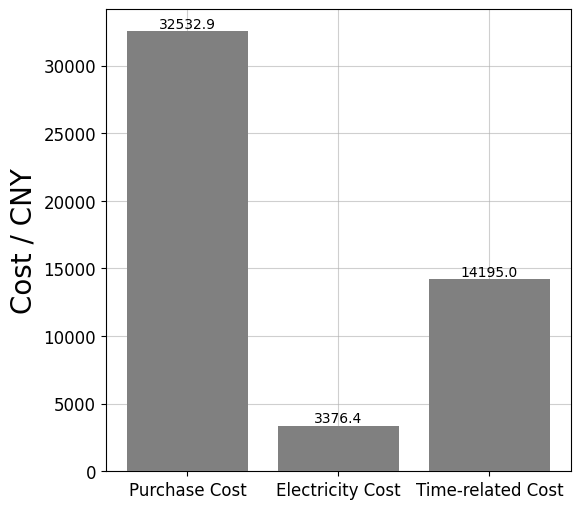

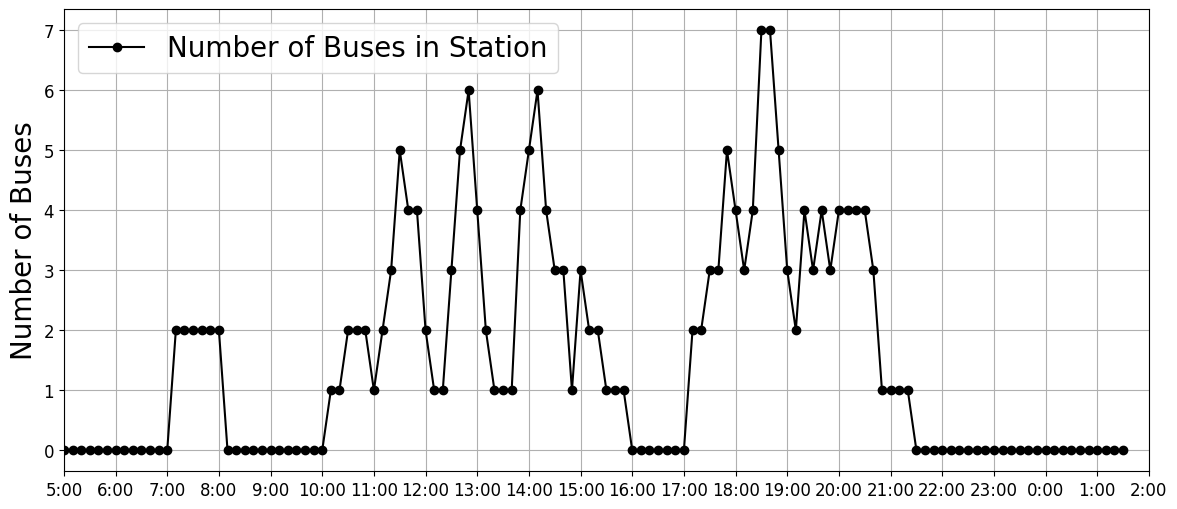

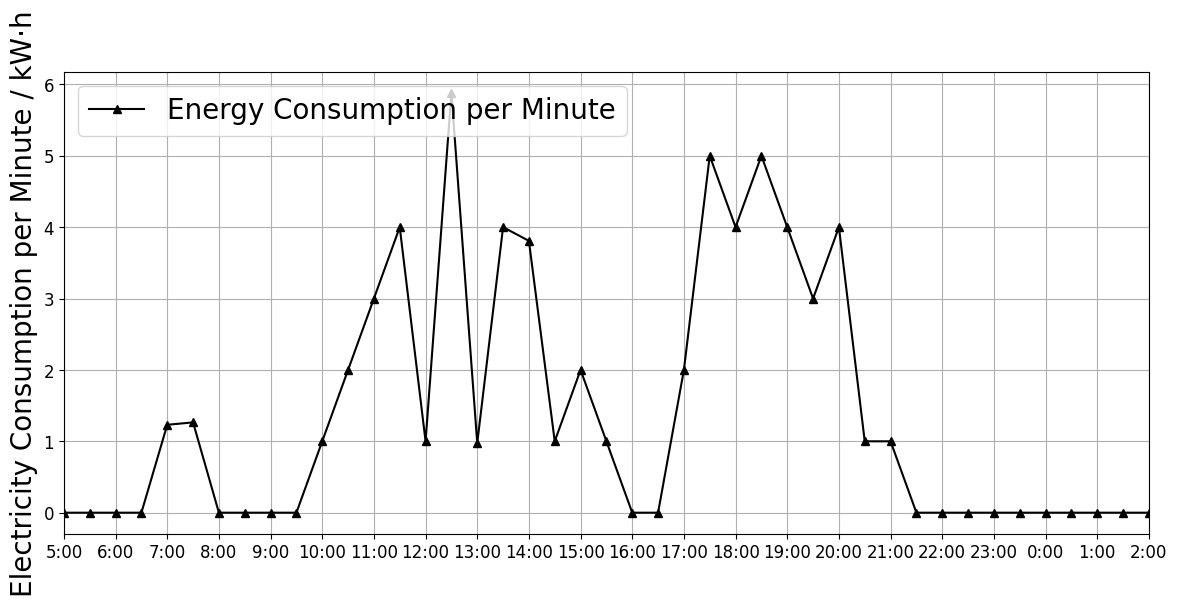

In [20]:
bestS.plotTimetable()
bestS.costBar()
bestS.chargerUsagePlot()
bestS.chargingPowerPlot()